# Using a Custom Elman RNN for MNIST Classification (row and sequential)

In this notebook, we implement a **custom Elman RNN** to classify the **MNIST dataset** in both **row-wise** and **sequential** formats.

### Overview of the Implementation:
We define two key components:
1. ````CustomRNNLayer```` – A single-layer recurrent neural network (Elman RNN).
2. ````RNNBackbone```` – A full RNN-based model that stacks one or more `CustomRNNLayer` instances and adds a ```final linear layer``` to classify MNIST digits.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
from tqdm import tqdm
import lightning as L

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys 
sys.path.append('../Flax')


In [2]:
if torch.cuda.is_available():
    print("CUDA is available")
    print(torch.cuda.get_device_name())
    device = torch.device("cuda")
    print(device)
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())

else:
    print("CUDA is not available")
    device = torch.device("cpu")

# set random seed
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

CUDA is available
NVIDIA GeForce RTX 4090
cuda
0
1


In [3]:
from utils import create_mnist_classification_dataset

In [4]:
# Hyperparameters
BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_VERSION = "sequential" # "sequential" or "row"

# Create dataset
train_loader, val_loader, test_loader, n_classes, seq_length, in_dim = create_mnist_classification_dataset(
    bsz=BATCH_SIZE, version=DATASET_VERSION
)

# split the dataset into train and validation
train_size = int(0.8 * len(train_loader.dataset))
valid_size = len(train_loader.dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_loader.dataset, [train_size, valid_size]
)

batch_images, batch_labels = next(iter(train_loader))
print(batch_images.shape)
print(batch_labels.shape)


[*] Generating MNIST Classification Dataset...
(128, 784, 1)
(128,)


In [20]:
# Create model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wx = nn.Linear(input_size, 4*hidden_size, bias=True)
        self.Wh = nn.Linear(hidden_size, 4*hidden_size, bias=False)
        for name, param in self.named_parameters():
            print(name)
            if 'Wx' and 'weight' in name:
                k = np.sqrt(1/input_size)
                nn.init.normal_(param, mean=0, std=k)
                param.data = torch.clamp(param.data, -2*k, 2*k)
                print(param.data.shape)
                print(param.data.mean())
                print(param.data.std())
            if 'Wh' in name:
                nn.init.orthogonal_(param)


    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        device = x.device
        h = torch.zeros(batch_size, self.hidden_size).to(device)
        c = torch.zeros(batch_size, self.hidden_size).to(device)
        h_hist = torch.zeros(batch_size, seq_len, self.hidden_size, device=device)
        c_hist = torch.zeros(batch_size, seq_len, self.hidden_size, device=device)
        for t in range(seq_len):
            x_t = x[:, t, :]
            f_i_xtilde_o = self.Wx(x_t) + self.Wh(h)
            f, i, x_t, o = torch.chunk(f_i_xtilde_o, 4, dim=1)
            f = torch.sigmoid(f)    
            i = torch.sigmoid(i)
            x_tilde = torch.tanh(x_t)
            o = torch.sigmoid(o)
            new_c = f * c + i * x_tilde
            new_h = o * torch.tanh(new_c)
            h_hist[:, t, :] = new_h
            c_hist[:, t, :] = new_c
        return (h_hist, c_hist), (h, c) # state_hist and last hidden state to match nn.RNN output

class LightningRNNBackbone(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, criterion, batch_size, n_layers=1, lr=1e-3):
        '''
        RNN backbone using 1 recurrent layer and 1 readout layer
        '''
        super().__init__()
        self.batch_size = batch_size
        self.criterion = criterion
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.lr = lr
        self.rnn_layers = nn.ModuleList([LSTM(input_size, hidden_size)])
        for _ in range(n_layers-1):
            print("Adding layer")
            self.rnn_layers.append(LSTM(hidden_size, hidden_size))
        self.W_out = nn.Linear(hidden_size, output_size, bias=True)
        self.logger_kwargs = {"batch_size": batch_size, "on_epoch": True, "on_step":True, "prog_bar": True}

    def forward(self, x):
        # x shape: [seq_len, input_size] or [batch_size, seq_len, input_size]
        
        # state_hist, out_hist = self.rnn_layer(x)
        for rnn_layer in self.rnn_layers:
            state_hist, _ = rnn_layer(x)
            x = state_hist[0]
        out_hist = self.W_out(x)
        return x, out_hist
    
    def run_batch(self, batch):
        # x shape: [seq_len, input_size] or [batch_size, seq_len, input_size]
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.long).to(self.device)
        # state_hist, out_hist = self.rnn_layer(x)
        state_hist, out_hist = self(x)
        final_outputs = out_hist.mean(dim=1)
        loss = self.criterion(final_outputs, y)
        one_hot = torch.zeros_like(final_outputs)
        one_hot[torch.arange(len(y)), y] = 1
        accuracy = (final_outputs.argmax(dim=1) == y).float().mean()
        return loss, accuracy

    
    def training_step(self, batch, batch_idx):

        loss, acc = self.run_batch(batch)
        # Logging to TensorBoard (if installed) by default
        # self.log("train_loss", loss, prog_bar=True, on_epoch=True, batch_size=128)
        self.log("train_loss", loss, **self.logger_kwargs) 
        self.log("train_acc", acc, **self.logger_kwargs)

        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        loss, acc = self.run_batch(batch)
        self.log("val_loss", loss, **self.logger_kwargs) 
        self.log("val_acc", acc, **self.logger_kwargs)
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        loss, acc = self.run_batch(batch)
        self.log("test_loss", loss, **self.logger_kwargs) 
        self.log("test_acc", acc, **self.logger_kwargs)
        return loss

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [21]:
HIDDEN_SIZE = 256
N_LAYERS = 1
LEARNING_RATE = 0.001
EPOCHS = 5

model = LightningRNNBackbone(in_dim, HIDDEN_SIZE, n_classes, nn.CrossEntropyLoss(), BATCH_SIZE, N_LAYERS, LEARNING_RATE)
print(model)
model.to(device)
print(model.device)


Wx.weight
torch.Size([1024, 1])
tensor(0.0405)
tensor(0.9693)
Wx.bias
Wh.weight
torch.Size([1024, 256])
tensor(0.0004)
tensor(0.9607)
LightningRNNBackbone(
  (criterion): CrossEntropyLoss()
  (rnn_layers): ModuleList(
    (0): LSTM(
      (Wx): Linear(in_features=1, out_features=1024, bias=True)
      (Wh): Linear(in_features=256, out_features=1024, bias=False)
    )
  )
  (W_out): Linear(in_features=256, out_features=10, bias=True)
)
cuda:0


In [22]:
model.rnn_layers[0].Wh.weight.min(), model.rnn_layers[0].Wh.weight.max() 

(tensor(-0.1503, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1424, device='cuda:0', grad_fn=<MaxBackward1>))

In [23]:
# from lightning.pytorch.callbacks import RichProgressBar

# # train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# callbacks = [RichProgressBar(leave=True)]
from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger("logs/", name="rnn_experiment")

from lightning.pytorch.callbacks import TQDMProgressBar
callbacks = [TQDMProgressBar(leave=True)]
trainer = L.Trainer(max_epochs=EPOCHS, callbacks=callbacks,
                    log_every_n_steps=50,
                    #limit_train_batches=200, 
                    enable_progress_bar=True, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0      | train
1 | rnn_layers | ModuleList       | 264 K  | train
2 | W_out      | Linear           | 2.6 K  | train
--------------------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.067     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s]

/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 390/390 [02:36<00:00,  2.49it/s, v_num=88, train_loss_step=1.980, train_acc_step=0.219, val_loss_step=1.980, val_acc_step=0.266, val_loss_epoch=2.050, val_acc_epoch=0.237, train_loss_epoch=2.050, train_acc_epoch=0.232]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
# test the model
trainer.test(model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 78/78 [00:08<00:00,  9.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.22606170177459717    │
│      test_loss_epoch      │    2.0947444438934326     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.0947444438934326,
  'test_acc_epoch': 0.22606170177459717}]

In [25]:
batch_images, batch_labels = next(iter(test_loader))
batch_images = torch.tensor(batch_images, dtype=torch.float32).to(device)
batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

print(batch_images.device)
print(batch_labels.device)
print(model.device)
model.to(device)
model.eval()
with torch.no_grad():
    state_hist, out_hist = model(batch_images)
    final_outputs = out_hist.mean(dim=1)
    preds = final_outputs.argmax(dim=1)
    accuracy = (preds == batch_labels).float().mean()
    print(f"Accuracy: {accuracy.item() * 100:.2f}%")
    print(f"Predictions: {preds}")
    print(f"Ground Truth: {batch_labels}")
    print(f"Loss: {F.cross_entropy(final_outputs, batch_labels)}")
    

cuda:0
cuda:0
cpu
Accuracy: 22.66%
Predictions: tensor([7, 6, 1, 0, 7, 1, 7, 7, 2, 2, 6, 6, 7, 6, 1, 7, 7, 7, 0, 1, 6, 7, 7, 7,
        1, 0, 1, 7, 0, 1, 7, 1, 6, 7, 6, 6, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1,
        0, 7, 7, 0, 7, 1, 0, 6, 6, 1, 6, 1, 7, 0, 1, 7, 2, 1, 7, 7, 0, 6, 7, 0,
        6, 6, 1, 7, 1, 7, 7, 0, 7, 6, 0, 1, 6, 0, 6, 6, 6, 1, 6, 7, 1, 0, 7, 0,
        1, 6, 7, 6, 7, 6, 6, 7, 7, 7, 2, 1, 7, 7, 6, 1, 1, 7, 1, 1, 1, 6, 1, 6,
        0, 7, 1, 7, 7, 7, 6, 6], device='cuda:0')
Ground Truth: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
Loss: 2.02655029296875


Epoch 1:  86%|████████▋ | 337/390 [27:28<04:19,  0.20it/s, v_num=87, train_loss_step=2.040, train_acc_step=0.258, val_loss_step=2.140, val_acc_step=0.227, val_loss_epoch=2.170, val_acc_epoch=0.204, train_loss_epoch=2.240, train_acc_epoch=0.178]


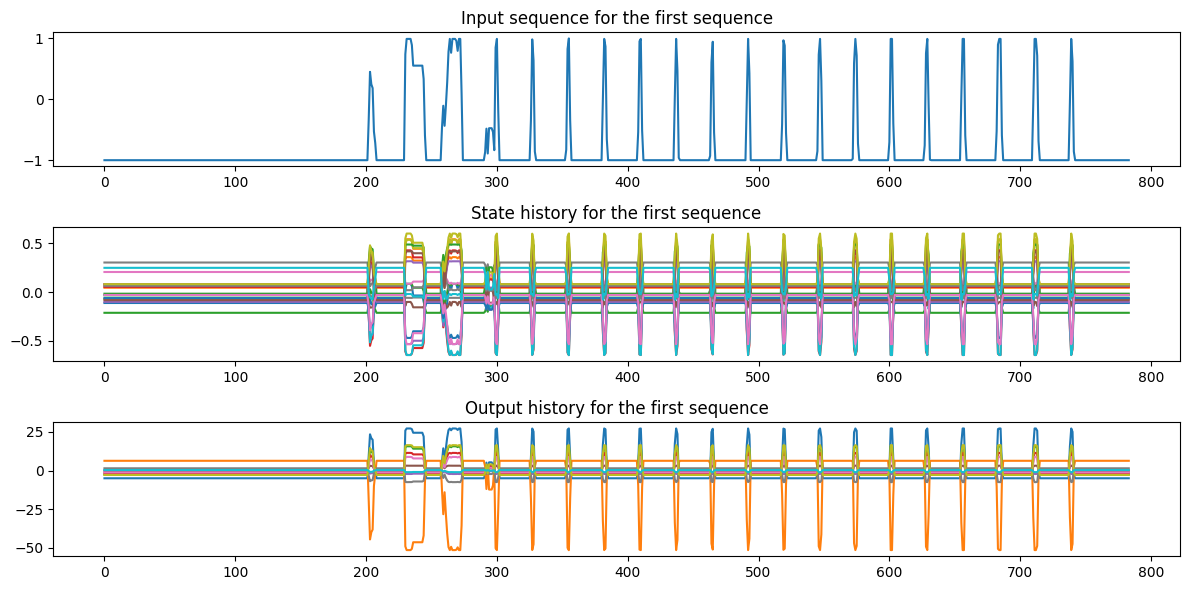

In [26]:
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']  # pixel in inches

fig, axs = plt.subplots(3, 1, figsize=(1200*px, 600*px))
axs[0].plot(batch_images[0].cpu().numpy())
axs[0].set_title("Input sequence for the first sequence")
axs[1].plot(state_hist[0, :, :20].cpu().numpy())
axs[1].set_title("State history for the first sequence")
axs[-1].plot(out_hist[0, :, :].cpu().numpy())
axs[-1].set_title("Output history for the first sequence")
# axs[1].set_yticks(np.arange(0,1.1, 0.1))
# axs[1].grid()
plt.tight_layout()
plt.show()

In [22]:
!pip freeze | grep torch

/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


pytorch-lightning==2.5.0.post0
torch==2.2.1+cu118
torchmetrics==1.6.1
torchvision==0.17.1+cu118
